In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re, pickle
import contractions as con
from string import punctuation
from Bert.custom_tokenizer import WordPieceTokenizer

# load pretraining data

with open('/home/bibek/dataset/raw_data.pkl','rb') as f:
    text = pickle.load(f)

In [2]:
# load trained wordpiece tokenizer

if __name__ == "__main__":

    with open('wp_tok_en.pkl','rb') as f:
        tok = pickle.load(f)
        


In [5]:
# data is split into short and long sequence of 32 and 128

# function to split data

def split_long_text(text,maxlen=200):
    if len(text.split()) > maxlen:
        sents = sent_tokenize(text)
        sents = [s.replace('\n','') for s in sents]
        output = []
        while True:
        
            tmp = []
            REM = False
            for i,s in enumerate(sents):
                s = s.split()[:maxlen]
                if len(tmp + s) <= maxlen:
                    tmp.extend(s)
                else:
                    REM = True
                    break
                    
            tmp = ' '.join(tmp)
                    
            output.append(tmp)
        
            if REM:
                sents = sents[i:]
            else:
                break
            
            
                
        return output
        
            
    
    else:
        return text
         
        
    


# data = []


short_maxlen = 32
long_maxlen = 128

short_seq = []
long_seq = []

for t in tqdm(text):
    x = split_long_text(t,short_maxlen-2)
    if type(x) == list:
        short_seq.extend(x)
    else:
        short_seq.append(x)
        
for t in tqdm(text):
    x = split_long_text(t,long_maxlen-2)
    if type(x) == list:
        long_seq.extend(x)
    else:
        long_seq.append(x)
    

len(long_seq),len(short_seq)

  0%|          | 0/1012132 [00:00<?, ?it/s]

  0%|          | 0/1012132 [00:00<?, ?it/s]

(1217961, 2457569)

In [6]:
long_seq[100],short_seq[100]

('you set me up .', "that ' s not")

In [7]:
len(long_seq),len(short_seq)

(1217961, 2457569)

In [8]:
from tqdm.auto import tqdm

# tokenize sequences and keep only the ones with atleast 10 tokens

tok.maxlen = 32
short_seq = [tok.tokenize(x) for x in tqdm(short_seq)]
short_seq = [x for x in short_seq if len(x) >= 10]


tok.maxlen = 128
long_seq = [tok.tokenize(x) for x in tqdm(long_seq)]
long_seq = [x for x in long_seq if len(x) >= 10]


  0%|          | 0/2457569 [00:00<?, ?it/s]

  0%|          | 0/1217961 [00:00<?, ?it/s]

In [9]:
# get percentage of samples with less than 5% unknown tokens 

print(len([x for x in long_seq if x.count(3)/len(x) <= 0.05])/len(long_seq))
print(len([x for x in short_seq if x.count(3)/len(x) <= 0.05])/len(short_seq))

0.9991363191010683
0.9990114674023951


<Axes: >

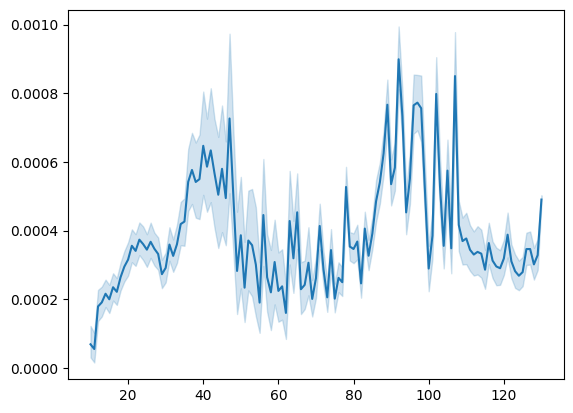

In [10]:
# plot unknown tokens percentage vs sequence length

unk_count_long = [x.count(3)/len(x) for x in long_seq]
unk_count_short = [x.count(3)/len(x) for x in short_seq]

total_count_long = [len(x) for x in long_seq]
total_count_short = [len(x) for x in short_seq]

sb.lineplot(x=total_count_long,y=unk_count_long)



<Axes: >

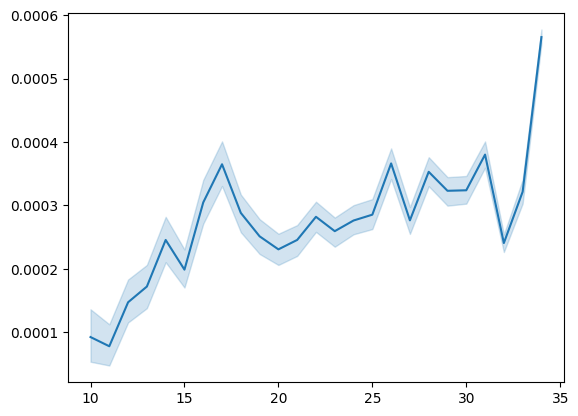

In [11]:
sb.lineplot(x=total_count_short,y=unk_count_short)

In [12]:

# keep only samples with less than 5% unknown tokens

long_seq = [x for x in long_seq if x.count(3)/len(x) <= 0.05]
short_seq = [x for x in short_seq if x.count(3)/len(x) <= 0.05]

In [14]:
# pad sequences

tok.maxlen = 32
short_seq = np.asarray([tok.add_padding(x) for x in tqdm(short_seq)],dtype=np.int16)

tok.maxlen = 128
long_seq = np.asarray([tok.add_padding(x) for x in tqdm(long_seq)],dtype=np.int16)


  0%|          | 0/2354699 [00:00<?, ?it/s]

  0%|          | 0/1136012 [00:00<?, ?it/s]

In [15]:
# shuffle data

np.random.shuffle(long_seq)
np.random.shuffle(short_seq)

len(long_seq),len(short_seq)

(1136012, 2354699)

In [16]:
long_seq[10],short_seq[10]

(array([    1,  3541,  2534,  2567,  2588,  1145,  2784,   708,  2486,
         8463,  1222,  2487,  2486, 15009,  3219,  2677, 15009,   499,
         2814,   708,  4468,  2508,  2533,  2971, 15007,   265,  2497,
         2524,  7606,  2523,  2543,    98,  3307,  3899,  2773,   498,
         2584,  2991, 15007,  2503,  2491,  2487,  5368,  3698,   500,
         2508,  4271, 15008,   265,  1135, 10450,    98,  3425,  2496,
          710,   498,  2486, 12203, 15008, 13496,  7752, 15007,  2500,
         2731,   708,  2761,  2502,   499,   710,   498,  2486,  1222,
        15009,    73,  6864,  6665, 15007,    98,  2529,  2588,  2491,
         2487,  5368,  3757,  2486,  6864,  2730, 15008,  2495,  2578,
        13496, 15009,    73,  2746,  4616,  2490,  2486,  3770, 15007,
         2500,  2497,  2518,  3812, 15008,  2487,   265,  2921,   520,
           49,  2267,    17,  2883,  1172,  1141,  2486,  5492,  2490,
         2486,  1502,   104,   462,  2464, 15007,     2,     0,     0,
      

In [17]:
# get most frequent tokens, punctuations and special tokens
# these tokens will not be masked

stopwords = nltk.corpus.stopwords.words('english')

def get_tok_k_tokens(k=20):
    top_k = [0,1,2,3]
    for token in tok.vocab:
        top_k.append(tok.w2i[token])
        if len(top_k) == k + 4:
            break
            
    for p in tok.vocab:
        if p in punctuation:
            top_k.append(tok.w2i[p])
    
    more = ['USER','LINK']
    more = [tok.w2i[t] for t in more]
    
    top_k = top_k + more
    
    return np.array(top_k)

dont_mask_toks = get_tok_k_tokens()

dont_mask_toks

array([    0,     1,     2,     3,     7,     8,     9,    10,    11,
          12,    13,    14,    15,    16,    17,    18,    19,    20,
          21,    22,    23,    24,    25,    26, 15007, 15008, 15009,
       15010, 15011, 15012, 15013, 15014, 15015, 15016, 15017, 15018,
       15019,     5,     6])

In [18]:
# sequence masking function

def create_masked_data(sequence,vocab_size,for_train=True,dont_mask_toks=np.asarray([0,1,2,3],np.int32),minlen=9):
    
    seq = np.asarray(sequence,dtype=np.int16)
    special_toks = np.array([0,1,2,3])
    
    # mask 12% of tokens
    end = np.where(seq == 2)[0][0]
    masked_seq = seq.copy()
    sep_idx = np.where(seq == tok.w2i['<sep>'])[0][0]
    n_mask = len(seq[1:sep_idx]) * 0.12 - 1
    mask = ~np.isin(seq, dont_mask_toks)
    
    if not any(mask):
        mask = ~np.isin(seq, special_toks)
    
    to_mask_idx = np.where(mask)[0]
    to_mask_prob = n_mask/len(to_mask_idx)
    probs = np.linspace(0,1,len(to_mask_idx))
    np.random.shuffle(probs)
    to_mask = masked_seq[to_mask_idx].copy()
    to_mask = np.where(probs>=to_mask_prob,to_mask,tok.w2i['<mask>'])
    masked_seq[to_mask_idx] = to_mask
    masked_idx = np.where(masked_seq == tok.w2i['<mask>'])[0]

    # replace 1% of tokens with random tokens (only for training data) 
    if for_train:
        non_masked_idx = np.where(masked_seq > tok.w2i['<mask>'])[0]
        num_tok_to_replace = int((len(seq) - 2) * 0.015)
        rand_idx = non_masked_idx[np.random.randint(0,len(non_masked_idx)-1,num_tok_to_replace)]
        rand_replacements = np.random.randint(len(tok.special_toks),vocab_size - len(tok.special_toks) - 1
                                              ,num_tok_to_replace)
        masked_seq[rand_idx] = rand_replacements

    return seq,masked_seq

In [23]:
# masking sample

x,y = create_masked_data(long_seq[10],vocab_size=len(tok.i2w),for_train=True,dont_mask_toks=dont_mask_toks)

print(' '.join([tok.i2w[t] for t in x if t>0]))
print()
print(' '.join([tok.i2w[t] for t in y if t>0]))

<cls> exactly two years later they return to the downtown club and the ' crime scene ' in order to celebrate their first meeting . sam has now transformed into being a private detective instead of police officer . when he and nancy sit at their table , sam is slipped a note from one of the singers , marge andrews . she wants to meet him in one of the club ' s dressing rooms . a while later he and nancy enter the dressing room , but find marge ' s body lying on the floor . she has been murdered , and sam sees st ##a ##in ##s probably left by the murderer on the rad ##i ##at ##or . <sep>

<cls> exactly two years later they return to the downtown club and the ' crime scene ' in order to celebrate their <mask> meeting . sam has now transformed <mask> being a private detective instead of <mask> officer . when he and nancy sit at their table , sam is slipped <mask> <mask> from one <mask> the singers , <mask> andrews . she <mask> to meet him in one of <mask> club ' s dressing rooms . a while 

In [24]:
# for storing masked and original sequence data

short_data = {'train':{'seq':[],'masked_seq':[]},
                    'valid':{'seq':[],'masked_seq':[]}}

long_data = {'train':{'seq':[],'masked_seq':[]},
                    'valid':{'seq':[],'masked_seq':[]}}


In [25]:
np.random.shuffle(long_seq)
np.random.shuffle(short_seq)

In [3]:
# split training and validation data (90:10 ratio)
# frequent tokens and punctuations will not be masked half of the time in training data

train,valid = [],[]
size = len(tok.i2w)

train_size = int(2e+6)
val_size = len(short_seq) - train_size - 1

for i,seq in enumerate(tqdm(short_seq)):
    
    if i <= val_size:
        if i % 2 == 0:
            seq,masked_seq = create_masked_data(seq,size,for_train=False)
        else:
            seq,masked_seq = create_masked_data(seq,size,for_train=False,dont_mask_toks=dont_mask_toks)
            
        if len(seq) > 0:
            valid.append((seq,masked_seq))
        
    else:
        if i % 2 == 0:
            seq,masked_seq = create_masked_data(seq,size,for_train=True)
        else:
            seq,masked_seq = create_masked_data(seq,size,for_train=True,dont_mask_toks=dont_mask_toks)
        if len(seq) > 0:
            train.append((seq,masked_seq))

NameError: name 'short_seq' is not defined

In [ ]:
# create short sequence pretraining data (1st phase)

for seq,masked in train:
    short_data['train']['masked_seq'].append(masked)
    short_data['train']['seq'].append(seq)
    
for seq,masked in valid:
    short_data['valid']['masked_seq'].append(masked)
    short_data['valid']['seq'].append(seq)

In [ ]:
# long sequences
# split training and validation data (90:10 ratio)
# frequent tokens and punctuations will not be masked half of the time in training data

train,valid = [],[]
size = len(tok.i2w)

train_size = int(1e+6)
val_size = len(long_seq) - train_size - 1

for i,seq in enumerate(tqdm(long_seq)):
    
    if i <= val_size:
        if i % 2 == 0:
            seq,masked_seq = create_masked_data(seq,size,for_train=False)
        else:
            seq,masked_seq = create_masked_data(seq,size,for_train=False,dont_mask_toks=dont_mask_toks)
            
        if len(seq) > 0:
            valid.append((seq,masked_seq))
        
    else:
        if i % 2 == 0:
            seq,masked_seq = create_masked_data(seq,size,for_train=True)
        else:
            seq,masked_seq = create_masked_data(seq,size,for_train=True,dont_mask_toks=dont_mask_toks)
        if len(seq) > 0:
            train.append((seq,masked_seq))

  0%|          | 0/1136012 [00:00<?, ?it/s]

In [ ]:
# create long sequence pretraining data (2nd phase)

for seq,masked in train:
    long_data['train']['masked_seq'].append(masked)
    long_data['train']['seq'].append(seq)
    
for seq,masked in valid:
    long_data['valid']['masked_seq'].append(masked)
    long_data['valid']['seq'].append(seq)

In [ ]:
# convert sequenctial data to array from list

short_data['train']['masked_seq'] = np.array(short_data['train']['masked_seq'],dtype=np.int16)
short_data['valid']['masked_seq'] = np.array(short_data['valid']['masked_seq'],dtype=np.int16)
short_data['train']['seq'] = np.array(short_data['train']['seq'],dtype=np.int16)
short_data['valid']['seq'] = np.array(short_data['valid']['seq'],dtype=np.int16)

long_data['train']['masked_seq'] = np.array(long_data['train']['masked_seq'],dtype=np.int16)
long_data['valid']['masked_seq'] = np.array(long_data['valid']['masked_seq'],dtype=np.int16)
long_data['train']['seq'] = np.array(long_data['train']['seq'],dtype=np.int16)
long_data['valid']['seq'] = np.array(long_data['valid']['seq'],dtype=np.int16)

In [ ]:
# save the 2 pretraining data

with open('short_pretraining_data.pkl','wb') as f:
    pickle.dump(short_data,f)
    
with open('long_pretraining_data.pkl','wb') as f:
    pickle.dump(long_data,f)